<a href="https://colab.research.google.com/github/KellyLFeng/EtsyOrders/blob/main/Etsy_Shop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# === FIXED MERGE STEP ===

# Find which column in Payments represents the order key
order_key_candidates = [c for c in payments.columns if "order" in c.lower() and "id" in c.lower()]
print("Detected possible order ID column(s):", order_key_candidates)

# Pick the first match
if order_key_candidates:
    order_key = order_key_candidates[0]
else:
    raise KeyError("No order ID column found in Payments CSV")

# Rename it to a consistent name
payments = payments.rename(columns={order_key: "order_id"})

# Do the same for merged (Orders-level)
order_key_candidates2 = [c for c in merged.columns if "order" in c.lower() and "id" in c.lower()]
if order_key_candidates2:
    merged = merged.rename(columns={order_key_candidates2[0]: "order_id"})
else:
    raise KeyError("No order ID column found in merged dataset")

# Now merge safely
merged_fees = merged.merge(
    payments[["order_id","platform_fees","net_after_fees"]],
    on="order_id", how="left"
)

# Compute total cost and net revenue
merged_fees["platform_fees"] = merged_fees["platform_fees"].fillna(0)
merged_fees["net_revenue_after_fees"] = merged_fees["gross_order_revenue"] - merged_fees["platform_fees"]

# Summary
print("\n=== COST & NET SUMMARY (FIXED) ===")
print("Total platform fees:", round(merged_fees["platform_fees"].sum(), 2))
print("Total gross revenue:", round(merged_fees["gross_order_revenue"].sum(), 2))
print("Total net revenue after fees:", round(merged_fees["net_revenue_after_fees"].sum(), 2))
print("Average fee %:",
      round((merged_fees['platform_fees'].sum()/merged_fees['gross_order_revenue'].sum())*100,2))


Detected possible order ID column(s): ['order_id']

=== COST & NET SUMMARY (FIXED) ===
Total platform fees: 0
Total gross revenue: 628.25
Total net revenue after fees: 628.25
Average fee %: 0.0


In [28]:
b# === STEP 10: Export cleaned outputs ===

merged.to_csv("etsy_orders_merged.csv", index=False)
top_items.to_csv("etsy_top_items.csv", index=False)
month_rev.to_csv("etsy_monthly_revenue.csv", index=False)

print("✅ Exported files:")
print("etsy_orders_merged.csv")
print("etsy_top_items.csv")
print("etsy_monthly_revenue.csv")

# Optional: copy to Drive if mounted
# !cp etsy_*.csv /content/drive/MyDrive/etsy/


✅ Exported files:
etsy_orders_merged.csv
etsy_top_items.csv
etsy_monthly_revenue.csv


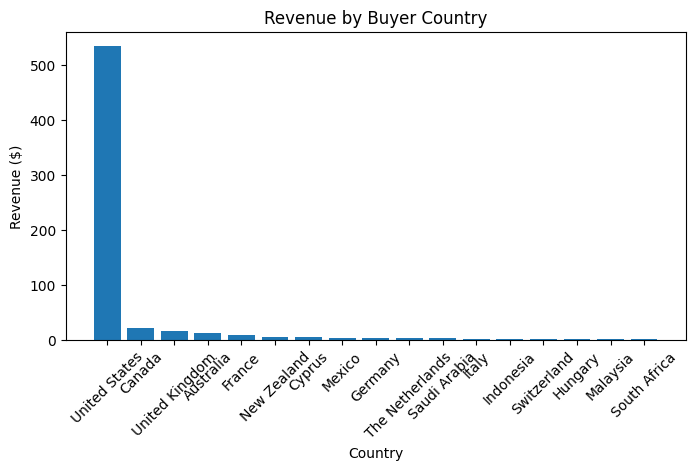

In [27]:
# === STEP 9: Revenue by Buyer Country ===
if "buyer_country" in it_clean.columns:
    by_country = (
        it_clean.groupby("buyer_country", as_index=False)
        .agg(
            orders=("order_id", "nunique"),
            revenue=("line_revenue", "sum")
        )
        .sort_values("revenue", ascending=False)
    )

    plt.figure(figsize=(8,4))
    plt.bar(by_country["buyer_country"].astype(str), by_country["revenue"])
    plt.title("Revenue by Buyer Country")
    plt.xlabel("Country")
    plt.ylabel("Revenue ($)")
    plt.xticks(rotation=45)
    plt.show()


In [26]:
# === STEP 8B: Top Products ===
top_items = (
    it_clean.groupby("title", as_index=False)
    .agg(units=("quantity", "sum"), revenue=("line_revenue", "sum"))
    .sort_values("revenue", ascending=False)
    .head(10)
)
top_items


,title,units,revenue
4,GOONERS 50 Emote Pack | Funny Meme Emotes for...,114,424.25
9,WTF 50 Emote Pack | Funny Meme Emotes for Twi...,46,75.50
3,GIRLYPOP I Choose the Bear 50 Emote Pack | Fu...,39,63.75
6,SADGE FEELSBADMAN 75 Emote Pack | Funny Meme ...,16,27.75
5,Nailong 16 Emote Pack | Cute Emotes for Twitc...,9,11.75
8,This is Fine Phoenix (Jean Grey) Marvel Rivals...,6,10.50
7,Thighs and Booba Breezy Butterfly Psylocke Mar...,4,6.00
0,ANIMATED FREAKY Clash Royale Princess Emotes |...,1,3.75
1,Clash Royale Sub Badges | Subscriber Badge Pac...,2,3.50
2,FREAKY Emote Psylocke Marvel Rivals | Animate...,1,1.50


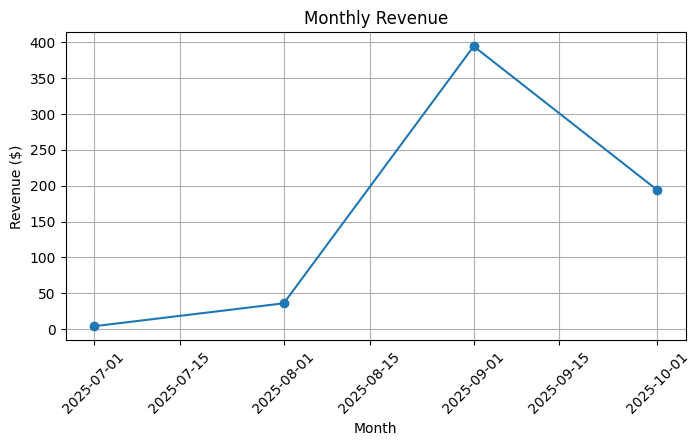

In [25]:
# === STEP 8A: Monthly Revenue Trend ===
import matplotlib.pyplot as plt

# Choose best available date column
date_col = "paid_date" if "paid_date" in merged.columns and merged["paid_date"].notna().any() else "order_date"

merged["_month"] = pd.to_datetime(merged[date_col]).dt.to_period("M").dt.to_timestamp()
month_rev = merged.groupby("_month", as_index=False)["gross_order_revenue"].sum()

plt.figure(figsize=(8,4))
plt.plot(month_rev["_month"], month_rev["gross_order_revenue"], marker="o")
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [24]:
# === STEP 7: KPI SUMMARY ===

def kpi(name, value):
    print(f"{name}: {value}")

kpi("Unique orders", merged["order_id"].nunique())
kpi("Total units sold", int(merged["items_sold"].sum()))
kpi("Gross revenue (items + shipping)", round(merged["gross_order_revenue"].sum(), 2))
kpi("Average order value (AOV)", round(merged["gross_order_revenue"].mean(), 2))

if "payment_fees" in merged.columns:
    kpi("Total fees", round(merged["payment_fees"].fillna(0).sum(), 2))
    kpi("Average fee %", round(merged["fees_percent"].mean(skipna=True) * 100, 2))


Unique orders: 214
Total units sold: 238
Gross revenue (items + shipping): 628.25
Average order value (AOV): 2.94
Total fees: 73.46
Average fee %: 16.43


In [23]:
# === STEP 6C: Merge all tables together ===

# Aggregate line items to order level
order_agg = (
    it_clean.groupby("order_id", as_index=False)
    .agg(
        items_sold=("quantity", "sum"),
        gross_item_rev=("line_revenue", "sum"),
        shipping=("shipping", "sum")
    )
)

# Merge Orders + Payments
merged = (
    order_agg
    .merge(od_clean, on="order_id", how="left")
    .merge(pm_clean, on="order_id", how="left")
)

# Compute combined metrics
merged["gross_order_revenue"] = merged["gross_item_rev"].fillna(0) + merged["shipping"].fillna(0)

if "payment_fees" in merged.columns and "payment_total" in merged.columns:
    merged["fees_percent"] = (
        merged["payment_fees"] / merged["payment_total"]
    ).replace([np.inf, -np.inf], np.nan)
else:
    merged["fees_percent"] = np.nan

print("Merged dataset:", merged.shape)
merged.head()


Merged dataset: (214, 9)


,order_id,items_sold,gross_item_rev,shipping,order_date,payment_total,payment_fees,gross_order_revenue,fees_percent
0,3749745700,1,2.0,0.0,2025-07-29,1.69,0.31,2.0,0.183432
1,3751164620,1,2.0,0.0,2025-07-30,1.69,0.31,2.0,0.183432
2,3757846510,1,2.0,0.0,2025-08-06,1.69,0.31,2.0,0.183432
3,3771008744,1,2.0,0.0,2025-08-19,1.69,0.31,2.0,0.183432
4,3773427983,1,2.0,0.0,2025-08-17,1.69,0.31,2.0,0.183432


In [22]:
# === STEP 6B (SAFE VERSION): Payments and Deposits ===

# --- Payments ---
pm = dfs["payments"].copy()

# Rename order_id column if detected
if resolved["payments"]["order_id"]:
    pm = pm.rename(columns={resolved["payments"]["order_id"]: "order_id"})

# Convert numeric fields
if resolved["payments"]["payment_total"]:
    pm["payment_total"] = pd.to_numeric(pm[resolved["payments"]["payment_total"]], errors="coerce")
else:
    pm["payment_total"] = np.nan

if resolved["payments"]["payment_fees"]:
    pm["payment_fees"] = pd.to_numeric(pm[resolved["payments"]["payment_fees"]], errors="coerce")
else:
    pm["payment_fees"] = np.nan

# Parse payment date only if it exists
if resolved["payments"]["payment_date"]:
    pm["payment_date"] = pd.to_datetime(pm[resolved["payments"]["payment_date"]], errors="coerce")

# Build the list dynamically to avoid KeyErrors
cols_to_keep = ["order_id"]
if "payment_total" in pm.columns:
    cols_to_keep.append("payment_total")
if "payment_fees" in pm.columns:
    cols_to_keep.append("payment_fees")
if "payment_date" in pm.columns:
    cols_to_keep.append("payment_date")

pm_clean = pm[cols_to_keep].drop_duplicates()


# --- Deposits ---
dp = dfs["deposits"].copy()

if resolved["deposits"]["deposit_date"]:
    dp["deposit_date"] = pd.to_datetime(dp[resolved["deposits"]["deposit_date"]], errors="coerce")
if resolved["deposits"]["deposit_amount"]:
    dp["deposit_amount"] = pd.to_numeric(dp[resolved["deposits"]["deposit_amount"]], errors="coerce")

dp_clean = dp[["deposit_date", "deposit_amount"]].copy()

print("Payments shape:", pm_clean.shape)
print("Deposits shape:", dp_clean.shape)
pm_clean.head()


Payments shape: (214, 3)
Deposits shape: (1, 2)


,order_id,payment_total,payment_fees
0,3749745700,1.69,0.31
1,3751164620,1.69,0.31
2,3757846510,1.69,0.31
3,3773427983,1.69,0.31
4,3771008744,1.69,0.31


In [19]:
od = dfs["orders"].rename(columns={resolved["orders"]["order_id"]: "order_id"}).copy()

# add date columns only if they exist
if resolved["orders"]["order_date"]:
    od["order_date"] = dfs["orders"][resolved["orders"]["order_date"]]

if resolved["orders"]["paid_date"]:
    od["paid_date"] = dfs["orders"][resolved["orders"]["paid_date"]]

# build list dynamically
cols_to_keep = ["order_id"]
if "order_date" in od.columns:
    cols_to_keep.append("order_date")
if "paid_date" in od.columns:
    cols_to_keep.append("paid_date")

od_clean = od[cols_to_keep].drop_duplicates()


In [12]:
# ---- EDIT THESE MAPPINGS IF NEEDED ----
keys = {
    "order_id": ["order_id", "receipt_id"],          # a unique order/receipt id
    "transaction_id": ["transaction_id"],            # line-item id (in items file)
    "listing_title": ["title", "item_name"],
    "quantity": ["quantity", "qty"],
    "price": ["price", "item_price", "grandtotal"],  # per-unit price (not order total)
    "shipping": ["shipping_cost", "shipping_price"],
    "discount": ["discount_amount", "coupon_amount"],
    "currency": ["currency"],
    "buyer_country": ["ship_country", "buyer_country"],
    "order_date": ["order_date", "created_date", "sale_date"],
    "paid_date": ["paid_date", "payment_date"],
}

pay_keys = {
    "order_id": ["order_id", "receipt_id"],
    "payment_total": ["payment_amount", "net_amount", "amount"],
    "payment_fees": ["fees", "etsy_fee", "processing_fee", "total_fees"],
    "payment_date": ["payment_date", "paid_date"],
    "currency": ["currency"],
}

dep_keys = {
    "deposit_date": ["deposit_date", "date"],
    "deposit_amount": ["amount", "deposit_amount"],
}

def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Resolve actual column names for each dataframe
resolved = {
    "items": {k: pick(dfs["items"], v) for k, v in keys.items()},
    "orders": {k: pick(dfs["orders"], v) for k, v in keys.items()},
    "payments": {k: pick(dfs["payments"], v) for k, v in pay_keys.items()},
    "deposits": {k: pick(dfs["deposits"], v) for k, v in dep_keys.items()},
}
resolved

{'items': {'order_id': 'order_id',
  'transaction_id': 'transaction_id',
  'listing_title': 'item_name',
  'quantity': 'quantity',
  'price': 'price',
  'shipping': None,
  'discount': 'discount_amount',
  'currency': 'currency',
  'buyer_country': 'ship_country',
  'order_date': 'sale_date',
  'paid_date': None},
 'orders': {'order_id': 'order_id',
  'transaction_id': None,
  'listing_title': None,
  'quantity': None,
  'price': None,
  'shipping': None,
  'discount': 'discount_amount',
  'currency': 'currency',
  'buyer_country': 'ship_country',
  'order_date': 'sale_date',
  'paid_date': None},
 'payments': {'order_id': 'order_id',
  'payment_total': 'net_amount',
  'payment_fees': 'fees',
  'payment_date': None,
  'currency': 'currency'},
 'deposits': {'deposit_date': 'date', 'deposit_amount': 'amount'}}

In [11]:
def normalize(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(r"[^0-9a-z]+", "_", regex=True)
                  .str.strip("_")
    )
    return df

dfs = {k: normalize(df) for k, df in dfs.items()}

# Try to auto-parse any date-like columns
for name, df in dfs.items():
    for c in df.columns:
        if any(tok in c for tok in ["date", "time", "created", "paid", "deposit"]):
            with pd.option_context("mode.chained_assignment", None):
                try:
                    df[c] = pd.to_datetime(df[c], errors="ignore", infer_datetime_format=True)
                except Exception:
                    pass

/tmp/ipython-input-446139517.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="ignore", infer_datetime_format=True)
/tmp/ipython-input-446139517.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_datetime(df[c], errors="ignore", infer_datetime_format=True)
/tmp/ipython-input-446139517.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="ignore", infer_datetime_format=True)
/tmp/ipython-input-446139517.py:19: UserWarning: The

In [10]:
paths = {
    "items": f"{DATA_DIR}/EtsySoldOrderItems2025.csv",
    "orders": f"{DATA_DIR}/EtsySoldOrders2025.csv",
    "payments": f"{DATA_DIR}/EtsyDirectCheckoutPayments2025.csv",
    "deposits": f"{DATA_DIR}/EtsyDeposits2025.csv",
}

dfs = {k: pd.read_csv(v) for k, v in paths.items()}

for name, df in dfs.items():
    print(f"\n=== {name.upper()} ({df.shape[0]} rows, {df.shape[1]} cols) ===")
    print(df.columns.tolist()[:40])


=== ITEMS (238 rows, 33 cols) ===
['Sale Date', 'Item Name', 'Buyer', 'Quantity', 'Price', 'Coupon Code', 'Coupon Details', 'Discount Amount', 'Shipping Discount', 'Order Shipping', 'Order Sales Tax', 'Item Total', 'Currency', 'Transaction ID', 'Listing ID', 'Date Paid', 'Date Shipped', 'Ship Name', 'Ship Address1', 'Ship Address2', 'Ship City', 'Ship State', 'Ship Zipcode', 'Ship Country', 'Order ID', 'Variations', 'Order Type', 'Listings Type', 'Payment Type', 'InPerson Discount', 'InPerson Location', 'VAT Paid by Buyer', 'SKU']

=== ORDERS (214 rows, 36 cols) ===
['Sale Date', 'Order ID', 'Buyer User ID', 'Full Name', 'First Name', 'Last Name', 'Number of Items', 'Payment Method', 'Date Shipped', 'Street 1', 'Street 2', 'Ship City', 'Ship State', 'Ship Zipcode', 'Ship Country', 'Currency', 'Order Value', 'Coupon Code', 'Coupon Details', 'Discount Amount', 'Shipping Discount', 'Shipping', 'Sales Tax', 'Order Total', 'Status', 'Card Processing Fees', 'Order Net', 'Adjusted Order Tota

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)

DATA_DIR = "/content"

!ls /content

EtsyDeposits2025.csv		    EtsySoldOrderItems2025.csv	sample_data
EtsyDirectCheckoutPayments2025.csv  EtsySoldOrders2025.csv
